# Main Classifiers used
In this notebook, we will show you all the classifiers used during the competion. 
Since we mainly focused on xgboost, we will see it in more detail

In [1]:
import csv
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier
import xgboost as xgb
from xgboost.sklearn import XGBClassifier

from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import normalize
from sklearn.model_selection import GridSearchCV
from sklearn import cross_validation, metrics

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

C:\Users\Jolyanne\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Load data

In [2]:
X_train = pd.read_csv('data/X_train_processed.csv')
X_test = pd.read_csv('data/X_test_processed.csv')
y_train = pd.read_csv('data/y_train_processed.csv')

In [3]:
X_train.head()

,cosine similarity (CS),total length (TL),difference length (DL),sim pos tags (POS),POS*DL,POS*TL,POS*POS*TL,POS*POS*DL,common words (CW),CW*POS,...,wc_diff_unique_stop,wc_ratio_unique_stop,same_start_word,same_last_word,char_diff,char_ratio,char_diff_unique_stop,q1_q2_intersect,qid1_max_kcore,qid2_max_kcore
0,0.516971,35.0,15.0,0.333333,5.000000,11.666667,3.888889,1.666667,1.0,0.333333,...,2.0,2.00,0.0,0.0,13.0,2.444444,13.0,0.0,0.0,0.4
1,0.499859,58.0,14.0,0.200000,2.800000,11.600000,2.320000,0.560000,2.0,0.400000,...,2.0,1.50,0.0,0.0,12.0,1.631579,12.0,0.0,0.0,0.0
2,0.690886,97.0,33.0,0.333333,11.000000,32.333333,10.777778,3.666667,3.0,1.000000,...,4.0,0.50,0.0,1.0,28.0,0.500000,24.0,0.0,1.0,1.0
3,0.931071,35.0,7.0,0.142857,1.000000,5.000000,0.714286,0.142857,3.0,0.428571,...,1.0,0.75,1.0,1.0,6.0,0.666667,6.0,3.0,1.0,1.0
4,0.238352,69.0,5.0,0.272727,1.363636,18.818182,5.132231,0.371901,2.0,0.545455,...,0.0,1.00,0.0,0.0,4.0,0.875000,0.0,0.0,0.0,0.0


Check nan values, be carefull sometimes its better with xgb to unchange them

In [4]:
X_train.isnull().sum().sum()

181

In [5]:
X_test.isnull().sum().sum()

76

In case we want to replace it by mean or 0 values.

In [6]:
for i in X_train.columns:
    X_train[i] = X_train[i].fillna(np.mean(X_train[i]))
    X_test[i] = X_test[i].fillna(np.mean(X_test[i]))

Creation of combine features.

As features 44 and 45 have decreased the loss a lot, we try to do some features engeenering, multiplying these features with others. 

In [7]:
index = [i for i in range(62)]
index.remove(60)
index.remove(61)

In [8]:
features = X_train.columns
featuresToTake = []
idxFeaturesToTake = index
print ("Features to take:")
for idx in idxFeaturesToTake:
    print ("-->\t", features[idx], ' ', idx)
    featuresToTake.append(features[idx])

Features to take:
-->	 cosine similarity (CS)   0
-->	 total length (TL)   1
-->	 difference length (DL)   2
-->	 sim pos tags (POS)   3
-->	 POS*DL   4
-->	 POS*TL   5
-->	 POS*POS*TL   6
-->	 POS*POS*DL   7
-->	 common words (CW)   8
-->	 CW*POS   9
-->	 CW*POS*DL   10
-->	 CW*POS*TL   11
-->	 fuzz ratio   12
-->	 fuzz partial_ratio   13
-->	 fuzz token_sort_ratio   14
-->	 fuzz token_set_ratio   15
-->	 fuzz partial_token_sort_ratio   16
-->	 jaro_distance   17
-->	 jaro_winkler   18
-->	 jaccard   19
-->	 jaccard_index n=2   20
-->	 jaccard_index_norm_a n=2   21
-->	 jaccard_index_norm_b n=2   22
-->	 jaccard_index n=3   23
-->	 jaccard_index_norm_a n=3   24
-->	 jaccard_index_norm_b n=3   25
-->	 jaccard_index n=4   26
-->	 jaccard_index_norm_a n=4   27
-->	 jaccard_index_norm_b n=4   28
-->	 jaccard_index n=5   29
-->	 jaccard_index_norm_a n=5   30
-->	 jaccard_index_norm_b n=5   31
-->	 pos_tag_cosine   32
-->	 pos_tag_euclidean   33
-->	 ner_tag_euclidean   34
-->	 ner_tag_coun

In [9]:
X_train = X_train[featuresToTake]
X_test = X_test[featuresToTake]

We add the target to the training matrice

In [10]:
X_train['target']  = y_train

In [14]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

We split matrice in training and testing part

In [15]:
train, test = train_test_split(X_train, test_size = 0.3)

In [16]:
y_train = train['target']
y_test = test['target']
del train['target']
del test['target']

## Classifiers

### Random Forest

In [28]:
rf = RandomForestClassifier(n_estimators = 200)
rf.fit(train, y_train)

y_proba_test = rf.predict_proba(test)
y_proba_train = rf.predict_proba(train)

test_loss = log_loss(y_test, y_proba_test, eps = 1e-15, normalize = True, sample_weight = None, labels = None)
print("test cross entropy = " + str(test_loss))
train_loss = log_loss(y_train, y_proba_train, eps = 1e-15, normalize = True, sample_weight = None, labels = None)
print("train cross entropy = " + str(train_loss))

test cross entropy = 0.20578188241466397
train cross entropy = 0.057597488777197385


### Gradient Boosting Classifier

In [29]:
Gbc = GradientBoostingClassifier(n_estimators = 200)
Gbc.fit(train, y_train)

y_proba_test = Gbc.predict_proba(test)
y_proba_train = Gbc.predict_proba(train)

test_loss = log_loss(y_test, y_proba_test, eps = 1e-15, normalize = True, sample_weight = None, labels = None)
print("test cross entropy = " + str(test_loss))
train_loss = log_loss(y_train, y_proba_train, eps = 1e-15, normalize = True, sample_weight = None, labels = None)
print("train cross entropy = " + str(train_loss))

test cross entropy = 0.1929647359610083
train cross entropy = 0.18335842090821616


### Adaboost

In [30]:
ada = AdaBoostClassifier(n_estimators = 300)
ada.fit(train, y_train)

y_proba_test = ada.predict_proba(test)
y_proba_train = ada.predict_proba(train)

test_loss = log_loss(y_test, y_proba_test, eps = 1e-15, normalize = True, sample_weight = None, labels = None)
print("test cross entropy = " + str(test_loss))
train_loss = log_loss(y_train, y_proba_train, eps = 1e-15, normalize = True, sample_weight = None, labels = None)
print("train cross entropy = " + str(train_loss))

test cross entropy = 0.6821992224176576
train cross entropy = 0.6820953448953657


## XGBoost with gridsearch and cross validation

##### Simple XGBoost

Preparation of matrice for a simple xgboost

In [31]:
dtrain = xgb.DMatrix(train, label = y_train)
dtest = xgb.DMatrix(test, label = y_test)
watchlist = [(dtrain, 'train'), (dtest, 'valid')]

In [32]:
param = {'max_depth': 2, 'eta':0.02, 'subsample' : 0.6,'base_score' : 0.2, "objective" : "binary:logistic", "eval_metric": "logloss"} 

bst = xgb.train(param, dtrain, 10000, watchlist, early_stopping_rounds=150, verbose_eval=50)

y_pred = bst.predict(dtest)
loss = log_loss(y_test, y_pred, eps = 1e-15, normalize = True, sample_weight = None, labels = None)
print("cross entropy = " + str(loss)) # the mean loss per sample.

[0]	train-logloss:1.08061	valid-logloss:1.0747
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 150 rounds.
[50]	train-logloss:0.419118	valid-logloss:0.418563
[100]	train-logloss:0.295377	valid-logloss:0.295876
[150]	train-logloss:0.254533	valid-logloss:0.25537
[200]	train-logloss:0.237098	valid-logloss:0.238278
[250]	train-logloss:0.228266	valid-logloss:0.229539
[300]	train-logloss:0.221349	valid-logloss:0.222788
[350]	train-logloss:0.21633	valid-logloss:0.218004
[400]	train-logloss:0.21205	valid-logloss:0.214076
[450]	train-logloss:0.208928	valid-logloss:0.21118
[500]	train-logloss:0.20624	valid-logloss:0.208806
[550]	train-logloss:0.204018	valid-logloss:0.206772
[600]	train-logloss:0.202325	valid-logloss:0.205312
[650]	train-logloss:0.200657	valid-logloss:0.20387
[700]	train-logloss:0.199214	valid-logloss:0.202702
[750]	train-logloss:0.197956	valid-logloss:0.201641
[800]	train-logloss:0.196797

XGB Wrapper in scikit learn

In [33]:
alg = XGBClassifier(
 learning_rate = 0.1,
 n_estimators= 1000,
 max_depth=2,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

alg.fit(train, y_train, eval_metric='logloss')

dtest_predprob = alg.predict_proba(test)[:,1]

loss = log_loss(y_test, dtest_predprob, eps = 1e-15, normalize = True, sample_weight = None, labels = None)
print("cross entropy (test data) = " + str(loss)) 

cross entropy (test data) = 0.18878963978270674


##### Now, we try to tune our model with cross validation and gridsearch

##### With a simple cross validation

We rebuild our data. Just concatenate label and features in the same dataframe to pass it as an argument more easily.

In [57]:
train['target']  = y_train
test['target']  = y_test

Before proceeding further, lets define a function which will help us create XGBoost models and perform cross-validation.

In [34]:
def modelfit(alg, dtrain, dtest, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain['target'].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='logloss', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['target'],eval_metric='logloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    #Predict testing set:
    dtest_predictions = alg.predict(dtest[predictors])
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy  on training data: %.4g" % metrics.accuracy_score(dtrain['target'].values, dtrain_predictions))
    print ("Accuracy  on testing data: %.4g" % metrics.accuracy_score(dtest['target'].values, dtest_predictions))
    loss = log_loss(dtrain['target'], dtrain_predprob, eps = 1e-15, normalize = True, sample_weight = None, labels = None)
    print("cross entropy (train data) = " + str(loss))
    loss = log_loss(dtest['target'], dtest_predprob, eps = 1e-15, normalize = True, sample_weight = None, labels = None)
    print("cross entropy (test data) = " + str(loss)) 

    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')
    return alg

Step 1: Fix learning rate and number of estimators for tuning tree-based parameters

In [40]:
predictors = [x for x in train.columns if x not in ['target']]

In [53]:
xgb1 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=2,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)

Without cross validation


Model Report
Accuracy  on training data: 0.9246
Accuracy  on testing data: 0.9157
cross entropy (train data) = 0.1692782742217093
cross entropy (test data) = 0.18878963978270674


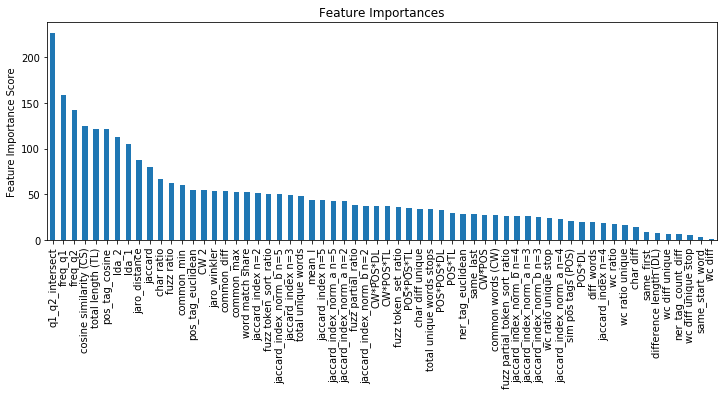

In [54]:
m1 = modelfit(xgb1, train, test, predictors, False)

With cross validation


Model Report
Accuracy  on training data: 0.9246
Accuracy  on testing data: 0.9157
cross entropy (train data) = 0.1692782742217093
cross entropy (test data) = 0.18878963978270674


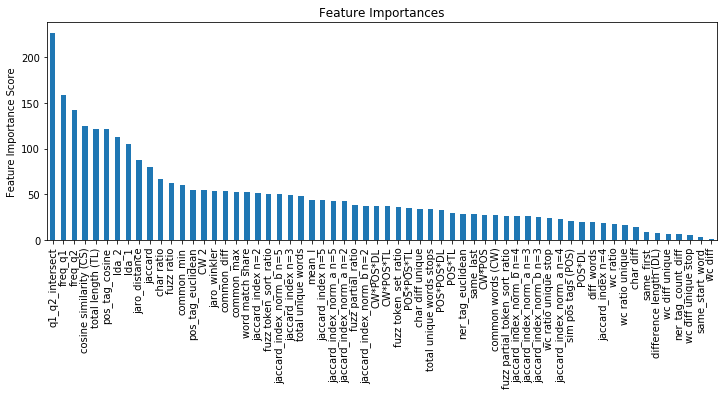

In [56]:
m1bis = modelfit(xgb1, train, test, predictors)

Step 2: Tune max_depth and min_child_weight

In [44]:
param_test1 = {
 'max_depth':range(4,10,2), #we test 4, 6 et 8
 'min_child_weight':range(1,6,2) #1, 3, 5
}
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate = 0.1, n_estimators=140, max_depth=5,
 min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
 param_grid = param_test1, scoring='neg_log_loss',n_jobs=4,iid=False, cv=None)
gsearch1.fit(X_train[predictors], X_train['target'])
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.19010, std: 0.00198, params: {'max_depth': 4, 'min_child_weight': 1},
  mean: -0.19026, std: 0.00236, params: {'max_depth': 4, 'min_child_weight': 3},
  mean: -0.19032, std: 0.00217, params: {'max_depth': 4, 'min_child_weight': 5},
  mean: -0.18688, std: 0.00236, params: {'max_depth': 6, 'min_child_weight': 1},
  mean: -0.18692, std: 0.00279, params: {'max_depth': 6, 'min_child_weight': 3},
  mean: -0.18717, std: 0.00266, params: {'max_depth': 6, 'min_child_weight': 5},
  mean: -0.18737, std: 0.00271, params: {'max_depth': 8, 'min_child_weight': 1},
  mean: -0.18692, std: 0.00244, params: {'max_depth': 8, 'min_child_weight': 3},
  mean: -0.18678, std: 0.00319, params: {'max_depth': 8, 'min_child_weight': 5}],
 {'max_depth': 8, 'min_child_weight': 5},
 -0.18678163765998632)

We optimize again the parameters

In [45]:
param_test2 = {
 'max_depth':[7,8,9],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
 min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test2, scoring = 'neg_log_loss',n_jobs=4,iid=False, cv=None)
gsearch2.fit(X_train[predictors], X_train['target'])
gsearch2.grid_scores_, gsearch2.best_params_, gsearch2.best_score_

([mean: -0.18613, std: 0.00254, params: {'max_depth': 7, 'min_child_weight': 4},
  mean: -0.18646, std: 0.00244, params: {'max_depth': 7, 'min_child_weight': 5},
  mean: -0.18660, std: 0.00227, params: {'max_depth': 7, 'min_child_weight': 6},
  mean: -0.18691, std: 0.00277, params: {'max_depth': 8, 'min_child_weight': 4},
  mean: -0.18678, std: 0.00319, params: {'max_depth': 8, 'min_child_weight': 5},
  mean: -0.18662, std: 0.00262, params: {'max_depth': 8, 'min_child_weight': 6},
  mean: -0.18712, std: 0.00276, params: {'max_depth': 9, 'min_child_weight': 4},
  mean: -0.18656, std: 0.00264, params: {'max_depth': 9, 'min_child_weight': 5},
  mean: -0.18729, std: 0.00217, params: {'max_depth': 9, 'min_child_weight': 6}],
 {'max_depth': 7, 'min_child_weight': 4},
 -0.1861314403904343)

Step 3: Tune gamma


Now lets tune gamma value using the parameters already tuned above. Gamma can take various values but I’ll check for 5 values here.

In [46]:
param_test3 = {
 'gamma':[0.0, 0.1, 0.2, 0.3, 0.4]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=8,
 min_child_weight=5, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='neg_log_loss',n_jobs = 4, cv=None)
gsearch3.fit(X_train[predictors], X_train['target'])
gsearch3.grid_scores_, gsearch3.best_params_, gsearch3.best_score_

([mean: -0.18678, std: 0.00319, params: {'gamma': 0.0},
  mean: -0.18670, std: 0.00226, params: {'gamma': 0.1},
  mean: -0.18666, std: 0.00268, params: {'gamma': 0.2},
  mean: -0.18649, std: 0.00293, params: {'gamma': 0.3},
  mean: -0.18673, std: 0.00217, params: {'gamma': 0.4}],
 {'gamma': 0.3},
 -0.18649299767142077)

We update the model with best param founded previously


Model Report
Accuracy  on training data: 0.9988
Accuracy  on testing data: 0.9154
cross entropy (train data) = 0.03312534833203649
cross entropy (test data) = 0.20532236674603724


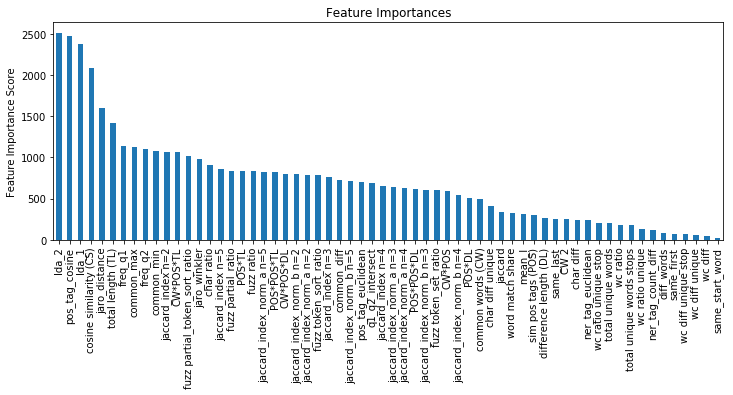

In [47]:
xgb2 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=7,
 min_child_weight=4,
 gamma=0.3,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
m2 = modelfit(xgb2, train, test, predictors, False)

As we can see, the new model overfit a lot, so we must reduce max depth or add regularization

Step 5: Tuning Regularization Parameters

Now, we apply regularization to reduce overfitting. 

In [48]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier(learning_rate = 0.1, n_estimators = 150, max_depth = 7,
 min_child_weight = 4, gamma = 0.3, subsample = 0.8, colsample_bytree = 0.8,
 objective = 'binary:logistic', nthread = 4, scale_pos_weight = 1, seed = 27), 
 param_grid = param_test6, scoring='neg_log_loss',n_jobs=4,iid=False, cv=5)
gsearch6.fit(X_train[predictors], X_train['target'])
gsearch6.grid_scores_, gsearch6.best_params_, gsearch6.best_score_

([mean: -0.18506, std: 0.00297, params: {'reg_alpha': 1e-05},
  mean: -0.18492, std: 0.00286, params: {'reg_alpha': 0.01},
  mean: -0.18511, std: 0.00287, params: {'reg_alpha': 0.1},
  mean: -0.18562, std: 0.00258, params: {'reg_alpha': 1},
  mean: -0.19950, std: 0.00223, params: {'reg_alpha': 100}],
 {'reg_alpha': 0.01},
 -0.18492442590914251)

Updating and testing new model


Model Report
Accuracy  on training data: 0.9571
Accuracy  on testing data: 0.9161
cross entropy (train data) = 0.11331394154411019
cross entropy (test data) = 0.1889672063908418


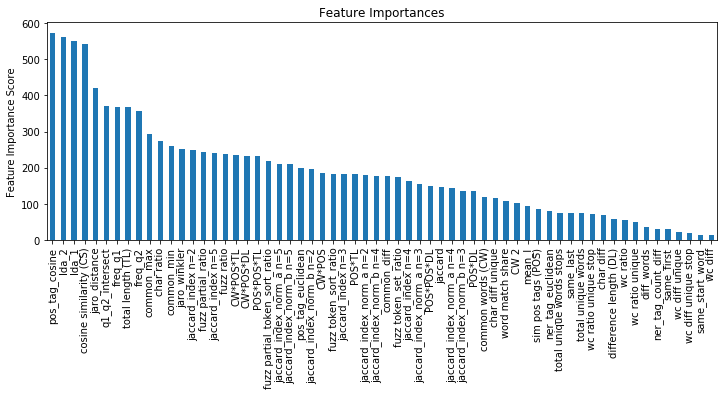

In [49]:
xgb3 = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=7,
 min_child_weight=4,
 gamma=0.3,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.01,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
m3 = modelfit(xgb3, train, test, predictors, False)

Step 6: Reducing Learning Rate

Lastly, we should lower the learning rate and add more trees. And as we overfitted a little, we reduce max depth


Model Report
Accuracy  on training data: 0.9272
Accuracy  on testing data: 0.9168
cross entropy (train data) = 0.16306103990184814
cross entropy (test data) = 0.18646962507615975


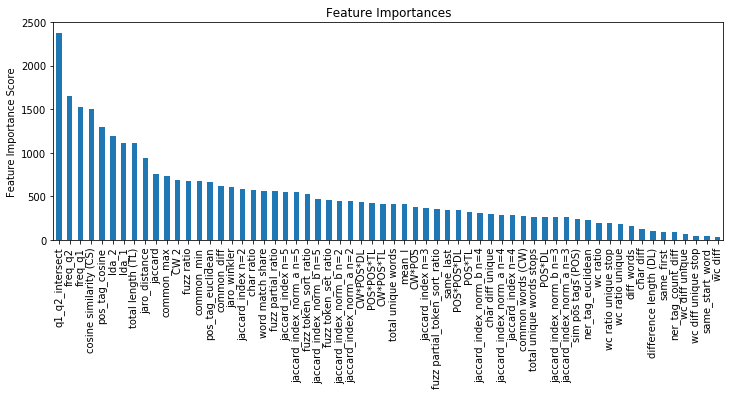

In [50]:
xgb4 = XGBClassifier(
 learning_rate = 0.01,
 n_estimators = 5000,
 max_depth = 3,
 min_child_weight = 4,
 gamma = 0.3,
 subsample=0.8,
 colsample_bytree=0.8,
 reg_alpha=0.01,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
finalmod = modelfit(xgb4, train, test, predictors, False)

To generate the final csv for the submission

In [51]:
y_pred = finalmod.predict_proba(X_test)
y_pred = y_pred[:, 1]

In [52]:
with open("submission_file.csv", 'w') as f:
    f.write("Id,Score\n")
    for i in range(len(y_pred)):
        f.write(str(i)
                +','
                +str(y_pred[i])+'\n')

#### If we want to retrain the model with the entire traning dataset

In [18]:
X_train = pd.read_csv('X_train_processed_real.csv', header=None)
X_test = pd.read_csv('X_test_processed_real.csv', header=None)
y_train = pd.read_csv('y_train_processed_real.csv', header=None)

In [19]:
for i in range(X_train.shape[1]):
    X_train[i] = X_train[i].fillna(np.mean(X_train[i]))
    X_test[i] = X_test[i].fillna(np.mean(X_test[i]))

In [20]:
for i in [31, 9]:
    del X_train[i] 
    del X_test[i] 

In [21]:
dtrain = xgb.DMatrix(X_train, label = y_train)
dtest = xgb.DMatrix(X_test)

In [22]:
param = {'max_depth': 2, 'eta':0.02, 'subsample' : 0.6,'base_score' : 0.2, "objective" : "binary:logistic", "eval_metric": "logloss"} 
num_round = 1000
bst = xgb.train(param, dtrain, num_round)
y_pred = bst.predict(dtest)

In [23]:
with open("submission_file.csv", 'w') as f:
    f.write("Id,Score\n")
    for i in range(len(y_pred)):
        f.write(str(i)
                +','
                +str(y_pred[i])+'\n')